In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

In [32]:
class PokemonNet:
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    @staticmethod
    def build_type2_branch(inputs, numType2, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType2)(x)
        x = Activation(finalAct, name="type2_classification")(x)
        
        return x
    
    @staticmethod
    def build_model(width, height, numType1, numType2, finalAct="sigmoid"):
        
        inputs = Input(shape=(width, height, 3))

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Constructing type 1 and type 2 heads.
        type1_branch = PokemonNet.build_type1_branch(x, numType1, finalAct)
        type2_branch = PokemonNet.build_type2_branch(x, numType2, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch, type2_branch],
            name="pokemonnet"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
        
        

In [33]:
EPOCHS = 50
BATCH_SIZE = 28
INIT_LR = 1e-3
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images\images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0
#plt.imshow(data[0,:,:,:])

# Binarize sets of labels
type1LB = LabelBinarizer()
type2LB = LabelBinarizer()
type1Labels = type1LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type1'))
type2Labels = type2LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type2'))

#ptypeLabels = label_dataset('Bug', 'pokemon_2.csv')
#print(ptypeLabels)

# Split data into training and validation
split = train_test_split(data, type1Labels, type2Labels, test_size=0.2)
(trainX, testX, trainType1Y, testType1Y, trainType2Y, testType2Y) = split

# defining dictionary with respective losses.
losses = {
    "type1_classification": "categorical_crossentropy",
    "type2_classification": "categorical_crossentropy",
}

# Creating model
model = PokemonNet.build_model(IMG_DIMS[0], IMG_DIMS[1], 
                               numType1=len(type1LB.classes_),
                               numType2=len(type2LB.classes_),
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss=losses, metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

"""
# train the network to perform multi-output classification
H = model.fit(x=trainX, 
        y={"type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data=(testX, 
            {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)
"""

# train the network to perform multi-output classification
H = model.fit(PokemonNet.net_generator(datagen, trainX, trainType1Y, trainType2Y, BATCH_SIZE),
        validation_data= PokemonNet.net_generator(datagen, testX, testType1Y, testType2Y, BATCH_SIZE),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

Building model...
Model: "pokemonnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 150, 150, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 150, 150, 32) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 50, 50, 32)   0           activation_42[0][0]              
_______________________________________________________________________

C:\Users\Alejandro de Leon\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Alejandro de Leon\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
20/20 [==============================] - 11s 506ms/step - loss: 5.3786 - type1_classification_loss: 2.8727 - type2_classification_loss: 2.5059 - type1_classification_accuracy: 0.1055 - type2_classification_accuracy: 0.3739 - val_loss: 4.6943 - val_type1_classification_loss: 2.7494 - val_type2_classification_loss: 1.9449 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 2/50
20/20 [==============================] - 10s 503ms/step - loss: 4.7348 - type1_classification_loss: 2.6657 - type2_classification_loss: 2.0691 - type1_classification_accuracy: 0.1722 - type2_classification_accuracy: 0.4957 - val_loss: 4.7741 - val_type1_classification_loss: 2.7500 - val_type2_classification_loss: 2.0241 - val_type1_classification_accuracy: 0.1605 - val_type2_classification_accuracy: 0.5247
Epoch 3/50
20/20 [==============================] - 10s 504ms/step - loss: 4.8280 - type1_classification_loss: 2.7099 - type2_classification_loss: 2.1181 - ty

In [15]:
# Save model
model.save('pokemon_model_11.h5', save_format='h5' )

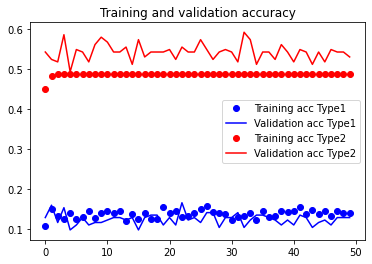

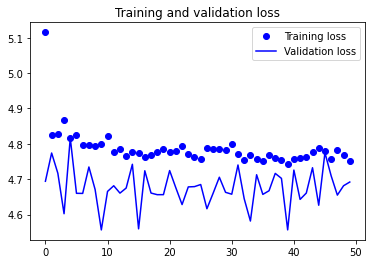

In [34]:
# Plot results

acc1 = H.history['type1_classification_accuracy']
acc2 = H.history['type2_classification_accuracy']
val_acc1 = H.history['val_type1_classification_accuracy']
val_acc2 = H.history['val_type2_classification_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc1))

plt.plot(epochs, acc1, 'bo', label='Training acc Type1')
plt.plot(epochs, val_acc1, 'b', label='Validation acc Type1')
plt.plot(epochs, acc2, 'ro', label='Training acc Type2')
plt.plot(epochs, val_acc2, 'r', label='Validation acc Type2')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("model11_1.png")
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("model11_2.png")
plt.show()


[INFO] loading network...
[INFO] classifying image...

 Type1: Bug Probability: 100.00% 
 Type2: Dragon Probability: 100.00%


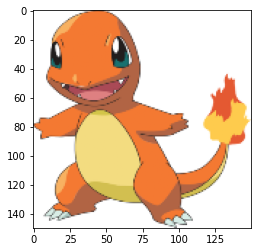

In [32]:
# Binarize sets of labels
type1LB = LabelBinarizer()
type2LB = LabelBinarizer()
type1Labels = type1LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type1'))
type2Labels = type2LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type2'))

# Test model
MODEL_PATH='pokemon_model_11.h5'
TEST_IMAGE='fire.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



In [3]:
class PokemonNet2:
    
    @staticmethod
    def build_fire_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="fire_output")(x)
        
        return x
        
    @staticmethod
    def build_water_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="water_output")(x)
        
        return x
    
    @staticmethod
    def build_grass_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="grass_output")(x)
        
        return x
    
    @staticmethod
    def build_normal_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="normal_output")(x)
        
        return x
    
    @staticmethod
    def build_bug_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="bug_output")(x)
        
        return x
    
    @staticmethod
    def build_rock_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="rock_output")(x)
        
        return x
    
    @staticmethod
    def build_electric_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="electric_output")(x)
        
        return x
    
    
    @staticmethod
    def build_model(width, height, finalAct="sigmoid"):
        
        inputs = Input(shape=(width, height, 3))

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Constructing 7 heads.
        fire_branch = PokemonNet2.build_fire_branch(x, finalAct)
        water_branch = PokemonNet2.build_water_branch(x, finalAct)
        grass_branch = PokemonNet2.build_grass_branch(x, finalAct)
        normal_branch = PokemonNet2.build_normal_branch(x, finalAct)
        bug_branch = PokemonNet2.build_bug_branch(x, finalAct)
        rock_branch = PokemonNet2.build_rock_branch(x, finalAct)
        electric_branch = PokemonNet2.build_electric_branch(x, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[fire_branch, water_branch, grass_branch, normal_branch, bug_branch, rock_branch, electric_branch],
            name="pokemonnet2"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
        
        

In [4]:
EPOCHS = 50
BATCH_SIZE = 28
INIT_LR = 1e-3
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images\images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0


# Creating labels for each type
fire_labels = label_dataset('Fire', 'pokemon_2.csv')
water_labels = label_dataset('Water', 'pokemon_2.csv')
grass_labels = label_dataset('Grass', 'pokemon_2.csv')
normal_labels = label_dataset('Normal', 'pokemon_2.csv')
bug_labels = label_dataset('Bug', 'pokemon_2.csv')
rock_labels = label_dataset('Rock', 'pokemon_2.csv')
electric_labels = label_dataset('Electric', 'pokemon_2.csv')


# Split data into training and validation
split = train_test_split(data, 
                         fire_labels,
                         water_labels,
                         grass_labels,
                         normal_labels,
                         bug_labels,
                         rock_labels, 
                         electric_labels,
                         test_size=0.2)

(trainX, 
 testX, 
 trainFireY, 
 testFireY, 
 trainWaterY, 
 testWaterY,
 trainGrassY,
 testGrassY,
 trainNormalY,
 testNormalY,
 trainBugY,
 testBugY,
 trainRockY,
 testRockY,
 trainElectricY,
 testElectricY) = split


# Creating model
model = PokemonNet2.build_model(IMG_DIMS[0], IMG_DIMS[1],
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

"""
# train the network to perform multi-output classification
H = model.fit(x=trainX, 
        y={"type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data=(testX, 
            {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)
"""

# train the network to perform multi-output classification
H = model.fit(trainX, y={
    "fire_output": trainFireY,
    "water_output": trainWaterY,
    "grass_output": trainGrassY,
    "normal_output": trainNormalY,
    "bug_output": trainBugY,
    "rock_output": trainRockY,
    "electric_output": trainElectricY},
              validation_data= (testX, {
                  "fire_output": testFireY,
                  "water_output": testWaterY,
                    "grass_output": testGrassY,
                    "normal_output": testNormalY,
                    "bug_output": testBugY,
                    "rock_output": testRockY,
                    "electric_output": testElectricY
                  
              }),
              steps_per_epoch=len(trainX)/BATCH_SIZE,
              validation_steps=len(testX)/BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

['abomasnow', 'Grass', 'Ice']
['abra', 'Psychic']
['absol', 'Dark']
['accelgor', 'Bug']
['aegislash-blade', 'Steel', 'Ghost']
['aerodactyl', 'Rock', 'Flying']
['aggron', 'Steel', 'Rock']
['aipom', 'Normal']
['alakazam', 'Psychic']
['alomomola', 'Water']
['altaria', 'Dragon', 'Flying']
['amaura', 'Rock', 'Ice']
['ambipom', 'Normal']
['amoonguss', 'Grass', 'Poison']
['ampharos', 'Electric']
['anorith', 'Rock', 'Bug']
['araquanid', 'Water', 'Bug']
['arbok', 'Poison']
['arcanine', 'Fire']
['arceus', 'Normal']
['archen', 'Rock', 'Flying']
['archeops', 'Rock', 'Flying']
['ariados', 'Bug', 'Poison']
['armaldo', 'Rock', 'Bug']
['aromatisse', 'Fairy']
['aron', 'Steel', 'Rock']
['articuno', 'Ice', 'Flying']
['audino', 'Normal']
['aurorus', 'Rock', 'Ice']
['avalugg', 'Ice']
['axew', 'Dragon']
['azelf', 'Psychic']
['azumarill', 'Water', 'Fairy']
['azurill', 'Normal', 'Fairy']
['bagon', 'Dragon']
['baltoy', 'Ground', 'Psychic']
['banette', 'Ghost']
['barbaracle', 'Rock', 'Water']
['barboach', 'Wate

In [12]:
model.save('pokemon_model_12.h5', save_format='h5')

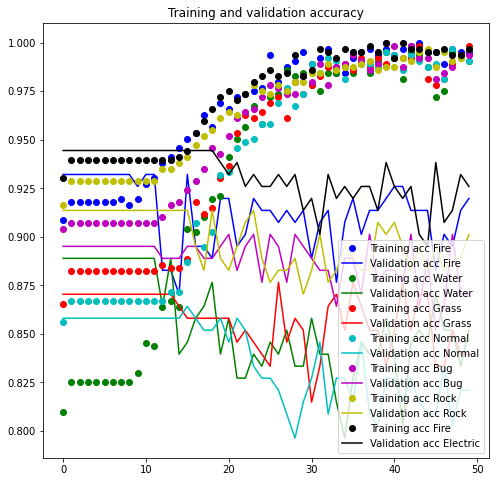

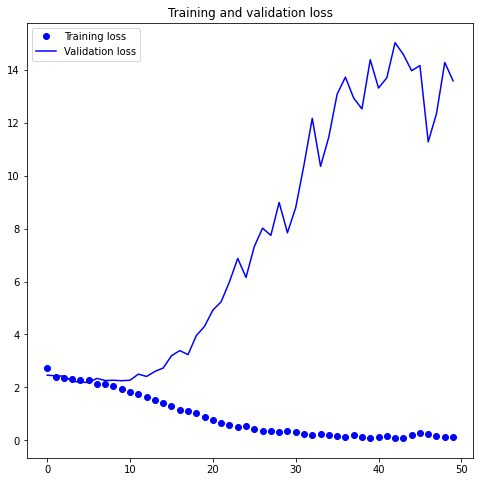

In [22]:
# Plot results

acc1 = H.history['fire_output_accuracy']
acc2 = H.history['water_output_accuracy']
acc3 = H.history['grass_output_accuracy']
acc4 = H.history['normal_output_accuracy']
acc5 = H.history['bug_output_accuracy']
acc6 = H.history['rock_output_accuracy']
acc7 = H.history['electric_output_accuracy']

val_acc1 = H.history['val_fire_output_accuracy']
val_acc2 = H.history['val_water_output_accuracy']
val_acc3 = H.history['val_grass_output_accuracy']
val_acc4 = H.history['val_normal_output_accuracy']
val_acc5 = H.history['val_bug_output_accuracy']
val_acc6 = H.history['val_rock_output_accuracy']
val_acc7 = H.history['val_electric_output_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc1))

plt.figure(figsize=(8,8))
plt.plot(epochs, acc1, 'bo', label='Training acc Fire')
plt.plot(epochs, val_acc1, 'b', label='Validation acc Fire')
plt.plot(epochs, acc2, 'go', label='Training acc Water')
plt.plot(epochs, val_acc2, 'g', label='Validation acc Water')
plt.plot(epochs, acc3, 'ro', label='Training acc Grass')
plt.plot(epochs, val_acc3, 'r', label='Validation acc Grass')
plt.plot(epochs, acc4, 'co', label='Training acc Normal')
plt.plot(epochs, val_acc4, 'c', label='Validation acc Normal')
plt.plot(epochs, acc5, 'mo', label='Training acc Bug')
plt.plot(epochs, val_acc5, 'm', label='Validation acc Bug')
plt.plot(epochs, acc6, 'yo', label='Training acc Rock')
plt.plot(epochs, val_acc6, 'y', label='Validation acc Rock')
plt.plot(epochs, acc7, 'ko', label='Training acc Fire')
plt.plot(epochs, val_acc7, 'k', label='Validation acc Electric')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("model12_1.png")

plt.figure(figsize=(8,8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("model12_2.png")
plt.show()


[INFO] loading network...
[INFO] classifying image...

 Fire: 0.00% 
 Water: 4.48% 
 Grass: 0.00% 
 Normal: 0.00% 
 Bug: 0.00% 
 Rock: 0.00% 
 Electric: 0.00% 


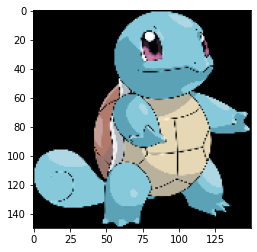

In [21]:
# Test model
MODEL_PATH='pokemon_model_12.h5'
TEST_IMAGE='water.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
fire, water, grass, normal, bug, rock, electric = model.predict(image)
print(f'\n Fire: {fire[0][0]*100:0.2f}% \n Water: {water[0][0]*100:0.2f}% \n Grass: {grass[0][0]*100:0.2f}% \n Normal: {normal[0][0]*100:0.2f}% \n Bug: {bug[0][0]*100:0.2f}% \n Rock: {rock[0][0]*100:0.2f}% \n Electric: {electric[0][0]*100:0.2f}% ')

